### Lecture 2, Intro to chroma feature computation: summing band energies

This notebook targets taking baby steps towards computing chromagrams: summing energies in bands(with octave wrap). It is a simplified example computed on a synthetic guitar sound for educational purposes. 

Your task is to implement the summing of spectrum amplitude in a 12-dimensional chroma vector which requires correctly mapping a frequency bin number to the index of the chroma vector. You are expected to write your code within the marked places in the second coding-cell: #Your code starts here .....#Your code ends here

In [1]:
import os
import sys
import numpy as np
from essentia.standard import *
from scipy.fftpack import fft
from scipy.signal import get_window
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import IPython.display as ipd

A4_HZ = 440
A4_MIDI = 69
NUM_NOTES_OCT = 12

In [2]:
#Initialize parameters
windowSize = 4096; hopSize = 2048; fs = 44100;
fftN = 4096
minFreq = 100
minFreqBin = round(minFreq * fftN / fs)
maxFreqBin = round(minFreq * pow(2,4) * fftN / fs)#consider 4 octaves for computation
midiNumbers = list(np.arange(60, 72))#C5-B5 range

#Read and normalize the signal
x = MonoLoader(filename = '../data/chroma/guitarOpenStrings_synth.mp3', sampleRate = fs)()
x = x / np.max(np.abs(x))

w = Windowing(type = 'hann')
mX = []
chroma = []
for frame in FrameGenerator(x, frameSize = windowSize, hopSize = hopSize):
    X = fft(w(frame),fftN)#computing fft
    ampSpec = np.abs(X[:int(fftN / 2)])#taking first half of the spectrum and its magnitude
    ampSpec[ampSpec < np.finfo(float).eps] = np.finfo(float).eps#getting rid of zeros before log in the next step
    mX.append(20 * np.log10(ampSpec))
    #summing energies
    bandEnergies = np.array([0.0] * 12)
    for freqBin in np.arange(minFreqBin,maxFreqBin):
        #Your code starts here
        # Write the code that maps freqBin to an integer midiNumber and adds
        # the amplitude of the spectrum at that bin at the 
        # corresponding component of 'bandEnergies' array
        freqBinHz = freqBin * fs / fftN
        binMidi = round(A4_MIDI + NUM_NOTES_OCT * np.log2(freqBinHz / A4_HZ))
        bandEnergies[np.mod(binMidi,12)] += ampSpec[freqBin]
        #Your code ends here
    bandEnergies = bandEnergies / np.sum(bandEnergies)
    chroma.append(bandEnergies)
        
mX = np.array(mX)
chroma = np.array(chroma)


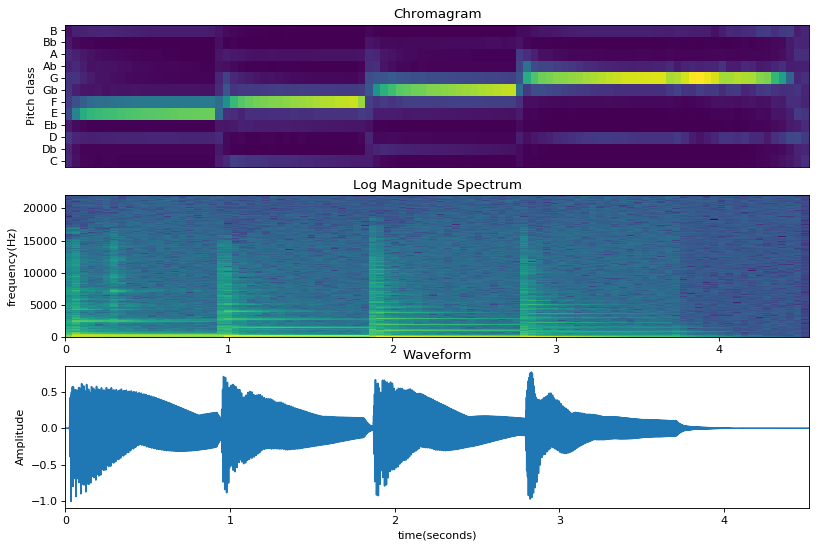

In [3]:
pitchClasses = ['C', 'Db', 'D', 'Eb', 'E', 'F', 'Gb', 'G', 'Ab','A', 'Bb', 'B']

fig = plt.figure(figsize = (12, 8), dpi = 80)

gs = matplotlib.gridspec.GridSpec(3, 1)
ax = plt.subplot(gs[0])
heatmap = ax.pcolor(chroma.transpose())
ax.tick_params(axis = 'x',which = 'both',top = 'off',bottom = 'off',labelbottom = 'off') 
ax.set_title('Chromagram')
ax.set_yticks(np.arange(chroma.shape[1]) + 0.5, minor = False)
ax.set_yticklabels(pitchClasses)
ax.set_ylabel('Pitch class')

ax = plt.subplot(gs[1])
timeAxSec = np.arange(mX.shape[0]) * hopSize / float(fs)
freqAx_normalized = np.arange(mX.shape[1]) / float(fftN)#Normalized frequency axis
freqAxHz = float(fs) * freqAx_normalized
ax.pcolormesh(timeAxSec, freqAxHz, np.transpose(mX))
ax.set_title('Log Magnitude Spectrum')
ax.set_ylabel('frequency(Hz)')

ax = plt.subplot(gs[2])
t = np.arange(x.size)/float(fs)
ax.plot(t,x)
ax.set_xlim([0, t[-1]])
ax.set_title('Waveform')
ax.set_ylabel('Amplitude')
ax.set_xlabel('time(seconds)')